<a href="https://colab.research.google.com/github/ab-sa/Statistical-Machine-Learning-2/blob/main/Lecture5_PCR_PLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline

Import Credit data

In [ ]:
Credit = pd.read_csv('Credit.csv')
print('Dimension of the data: ' + str(Credit.shape))
Credit.head()

Dimension of the data: (400, 12)


,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


PCR

[65941.19923531673, 65293.54345647095, 62786.90084440178, 57082.061186136074, 57106.769631649106]


Text(0, 0.5, 'MSPE')

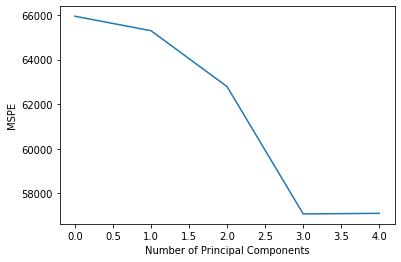

In [ ]:
y = Credit['Balance']
X = Credit[['Limit', 'Rating', 'Cards', 'Age', 'Education']]

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

pca = PCA()
PCs_train = pca.fit_transform(X_train_std)
PCs_test = pca.transform(X_test_std)

LModel = linear_model.LinearRegression()
MSPEs = []

# Calculate MSPE with only the intercept
#LModel.fit(np.ones((len(PCs_train),1)), y_train)
#MSPEs.append(mean_squared_error(y_test, LModel.predict(np.ones((len(PCs_test),1)))))

# Calculate MSPE: adding one component at a time
for i in np.arange(1, 6):
  LModel.fit(PCs_train[:,:i], y_train)
  MSPEs.append(mean_squared_error(y_test, LModel.predict(PCs_test[:,:i])))

print(MSPEs)

# Plot MSPEs results    
plt.plot(MSPEs)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSPE')

In [ ]:
LModel.fit(PCs_train[:,:4], y_train)
print('MSPE: ', mean_squared_error(y_test, LModel.predict(PCs_test[:,:4])))
print('Coef estimatees: ', LModel.coef_)

MSPE:  57082.061186136074
Coef estimatees:  [272.01834448  26.36588099 -40.84763767  64.45753523]


Create dummy variavles and initialize 10-fold CV

In [ ]:
# from numpy.core.fromnumeric import shape
Credit_dumms = pd.get_dummies(Credit)
Credit_dumms['CV'] = np.random.randint(low=0, high=10, size=(Credit_dumms.shape[0],))
print(Credit_dumms['CV'].value_counts())
print(Credit_dumms.isnull().sum())
Credit_dumms

6    50
9    44
3    44
5    43
0    42
4    38
1    37
7    36
8    33
2    33
Name: CV, dtype: int64
ID                            0
Income                        0
Limit                         0
Rating                        0
Cards                         0
Age                           0
Education                     0
Balance                       0
Gender_ Male                  0
Gender_Female                 0
Student_No                    0
Student_Yes                   0
Married_No                    0
Married_Yes                   0
Ethnicity_African American    0
Ethnicity_Asian               0
Ethnicity_Caucasian           0
CV                            0
dtype: int64


,ID,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_ Male,Gender_Female,Student_No,Student_Yes,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian,CV
0,1,14.891,3606,283,2,34,11,333,1,0,1,0,0,1,0,0,1,8
1,2,106.025,6645,483,3,82,15,903,0,1,0,1,0,1,0,1,0,9
2,3,104.593,7075,514,4,71,11,580,1,0,1,0,1,0,0,1,0,3
3,4,148.924,9504,681,3,36,11,964,0,1,1,0,1,0,0,1,0,5
4,5,55.882,4897,357,2,68,16,331,1,0,1,0,0,1,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,12.096,4100,307,3,32,13,560,1,0,1,0,0,1,0,0,1,6
396,397,13.364,3838,296,5,65,17,480,1,0,1,0,1,0,1,0,0,1
397,398,57.872,4171,321,5,67,12,138,0,1,1,0,0,1,0,0,1,9
398,399,37.728,2525,192,1,44,13,0,1,0,1,0,0,1,0,0,1,5


Model comparison:

In [ ]:
Ridge_MSPE = []
LASSO_MSPE = []
LASSO_NFeat = []
PCR_MSPE = []
PCR_NCopm = []
PLS_MSPE = []
PLS_NCopm = []

for i in range(10):
  Credit_dumms_train = Credit_dumms.loc[Credit_dumms['CV'] != i]
  Credit_dumms_test = Credit_dumms.loc[Credit_dumms['CV'] == i]

  y_train = Credit_dumms_train['Balance']
  X_train = Credit_dumms_train.drop(['ID', 'Balance', 'CV'], axis=1)
  y_test = Credit_dumms_test['Balance']
  X_test = Credit_dumms_test.drop(['ID', 'Balance', 'CV'], axis=1)

  std_scale = StandardScaler().fit(X_train)
  X_train_std = std_scale.transform(X_train)
  X_test_std  = std_scale.transform(X_test)

  CV10 = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

  # Ridge
  LMRidgeCV = RidgeCV(alphas=np.arange(0.5, 2, 0.01), cv=CV10, scoring='neg_mean_squared_error')
  LMRidgeCV.fit(X_train_std, y_train)
  LMRidge = Ridge(alpha = LMRidgeCV.alpha_)
  LMRidge.fit(X_train_std, y_train)
  Ridge_MSPE.append(mean_squared_error(y_test, LMRidge.predict(X_test_std)))

  # LASSO
  LMLassoCV = LassoCV(alphas = np.arange(0.5, 2, 0.01), cv = CV10, max_iter = 1000)
  LMLassoCV.fit(X_train_std, y_train)
  LMLasso = Lasso(max_iter = 10000)
  LMLasso.set_params(alpha=LMLassoCV.alpha_)
  LMLasso.fit(X_train_std, y_train)
  LASSO_MSPE.append(mean_squared_error(y_test, LMLasso.predict(X_test_std)))
  LASSO_NFeat.append(len(LMLasso.coef_) - sum(LMLasso.coef_ == 0))

  # PCR
  pca = PCA()
  LModel = linear_model.LinearRegression()
  for pcr_train_index, pcr_test_index in CV10.split(X_train_std):
    pcr_X_train, pcr_X_test = X_train_std[pcr_train_index], X_train_std[pcr_test_index]
    pcr_y_train, pcr_y_test = y_train.iloc[pcr_train_index], y_train.iloc[pcr_test_index]
    PCs_train = pca.fit_transform(pcr_X_train)
    PCs_test = pca.transform(pcr_X_test)
    PCR_MSPE_train = []
    for j in range(1, 16):
      LModel.fit(PCs_train[:,:j], pcr_y_train)
      PCR_MSPE_train.append(mean_squared_error(pcr_y_test, LModel.predict(PCs_test[:,:j])))

  PCR_NCopm.append(np.argmin(PCR_MSPE_train))
  PCs_train = pca.fit_transform(X_train_std)
  PCs_test = pca.transform(X_test_std)
  LModel.fit(PCs_train[:,:PCR_NCopm[i]], y_train)
  PCR_MSPE.append(mean_squared_error(y_test, LModel.predict(PCs_test[:,:PCR_NCopm[i]])))

  # PLS
  for pls_train_index, pls_test_index in CV10.split(X_train_std):
    pls_X_train, pls_X_test = X_train_std[pcr_train_index], X_train_std[pcr_test_index]
    pls_y_train, pls_y_test = y_train.iloc[pcr_train_index], y_train.iloc[pcr_test_index]
    PLS_MSPE_train = []
    for j in range(1, 16):
      plsr = PLSRegression(n_components=j, scale=True)
      plsr.fit(pls_X_train, pls_y_train)
      PLS_MSPE_train.append(mean_squared_error(pls_y_test, plsr.predict(pls_X_test)))

  PLS_NCopm.append(np.argmin(PLS_MSPE_train))
  plsr = PLSRegression(n_components=PLS_NCopm[i], scale=True)
  plsr.fit(X_train_std, y_train)
  PLS_MSPE.append(mean_squared_error(y_test, plsr.predict(X_test_std)))


print(Ridge_MSPE)
print(LASSO_MSPE)
print(LASSO_NFeat)
print(PCR_MSPE)
print(PCR_NCopm)
print(PLS_MSPE)
print(PLS_NCopm)

[8296.122231786563, 8280.851201388889, 8747.24800902244, 13439.20469615744, 7506.114745904266, 7950.970162440905, 10850.106956618481, 19341.951612000394, 9251.489657041455, 7658.498853082135]
[8085.426731365675, 8401.45895466392, 8883.897219251845, 13540.239387504349, 7379.807482004949, 7959.017731926349, 10931.682226107916, 19054.924524053236, 9126.543818550446, 7872.679397757668]
[12, 14, 13, 14, 12, 13, 13, 13, 14, 12]
[8182.859742423289, 56751.60479863782, 8790.392986280538, 13310.342691703077, 7574.0333016785, 7890.721066253184, 65730.57361487666, 19478.095696788438, 68904.21167968976, 55102.44381373068]
[14, 9, 10, 13, 10, 12, 9, 11, 9, 9]
[8253.483390933578, 8759.05971742573, 8673.222178697893, 13305.788670458081, 7570.8407361519485, 7946.438468785464, 14147.173000974006, 19494.940138461105, 13121.233207474274, 34885.02976155539]
[10, 4, 10, 8, 4, 9, 3, 10, 3, 2]


RMSPEs and side-bu-side boxplots:

RMSPE average for Ridge:  1.349866895929481
RMSPE average for LASSO:  1.3717929325397875
RMSPE average for PCR:  4.115578410818209
RMSPE average for PLS:  1.7984423925436115


[Text(0, 0, 'Ridge'),
 Text(0, 0, 'LASSO'),
 Text(0, 0, 'PCR'),
 Text(0, 0, 'PLS')]

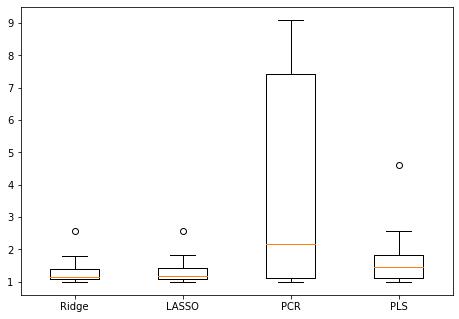

In [ ]:
RMSPE_Ridge = Ridge_MSPE / min(Ridge_MSPE)
RMSPE_LASSO = LASSO_MSPE / min(LASSO_MSPE)
RMSPE_PCR = PCR_MSPE / min(PCR_MSPE)
RMSPE_PLS = PLS_MSPE / min(PLS_MSPE)

print('RMSPE average for Ridge: ', np.mean(RMSPE_Ridge))
print('RMSPE average for LASSO: ', np.mean(RMSPE_LASSO))
print('RMSPE average for PCR: ', np.mean(RMSPE_PCR))
print('RMSPE average for PLS: ', np.mean(RMSPE_PLS))

RMSPEs = [RMSPE_Ridge, RMSPE_LASSO, RMSPE_PCR, RMSPE_PLS]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.boxplot(RMSPEs)
ax.set_xticklabels(['Ridge','LASSO','PCR', 'PLS'])